In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# adfuller test
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)  # p<0.05, Stationary

In [3]:
ten_stocks_close = pd.read_csv('Top 10 stocks.csv')

In [4]:
pool = ["600094.XSHG",    
        "600160.XSHG", 
        "600008.XSHG",
        "600903.XSHG",
        "000959.XSHE",
        "600970.XSHG",
        "002302.XSHE",
        "600823.XSHG",
        "002503.XSHE",
        "600664.XSHG"]

In [5]:
close_price = ten_stocks_close['600903.XSHG'].dropna()

## Ljung Box Test on close price

In [6]:
import statsmodels.api as sm
sm.stats.acorr_ljungbox(close_price, lags=[12], return_df=True) # The p-value closes to 0. Has dependency

,lb_stat,lb_pvalue
12,2365.436515,0.0


## Stationarity on close price first

In [7]:
test_stationarity(close_price) # p-value is smaller than 0.05

Results of Dickey-Fuller Test:
Test Statistic                  -3.179685
p-value                          0.021191
#Lags Used                       4.000000
Number of Observations Used    302.000000
Critical Value (1%)             -3.452190
Critical Value (5%)             -2.871158
Critical Value (10%)            -2.571895
dtype: float64


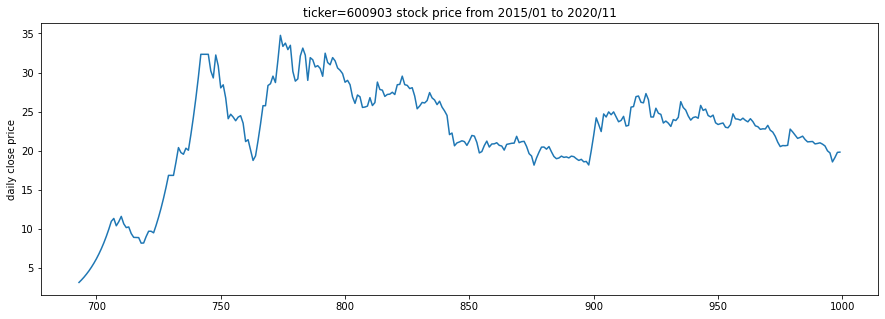

In [8]:
# visualize daily close data, lable y = column 1, ticker = 600094
close_price.plot(figsize=(15,5))
plt.ylabel('daily close price')
plt.title('ticker=600903 stock price from 2015/01 to 2020/11')
plt.show()

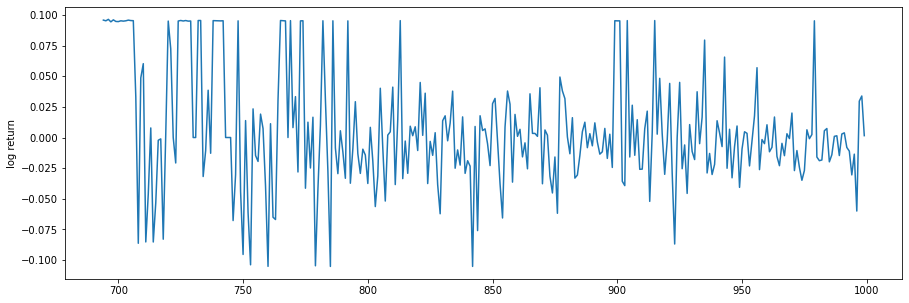

In [9]:
log_rtn = np.log(close_price).diff(1).dropna()
log_rtn.plot(figsize=(15,5))
plt.ylabel('log return')
plt.show()

## Test stationarity

In [10]:
test_stationarity(log_rtn) #p-value is small, it's stationary

Results of Dickey-Fuller Test:
Test Statistic                -5.848631e+00
p-value                        3.633304e-07
#Lags Used                     3.000000e+00
Number of Observations Used    3.020000e+02
Critical Value (1%)           -3.452190e+00
Critical Value (5%)           -2.871158e+00
Critical Value (10%)          -2.571895e+00
dtype: float64


## ACF & PACF

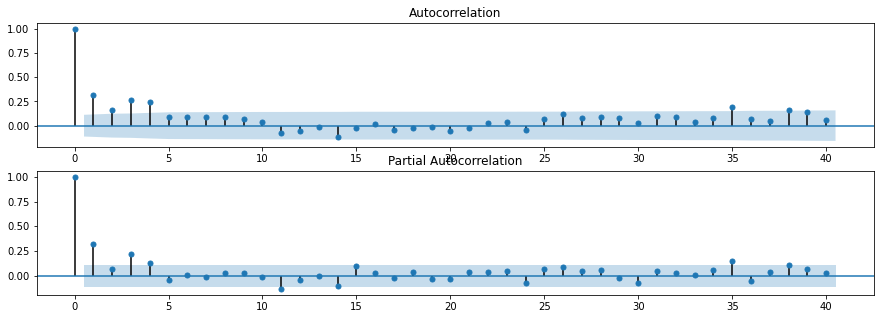

In [11]:
# acf & pacf for log return
import statsmodels.api as sm
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(log_rtn, lags=40, ax=ax1) 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(log_rtn, lags=40, ax=ax2)

## Distribution of log return

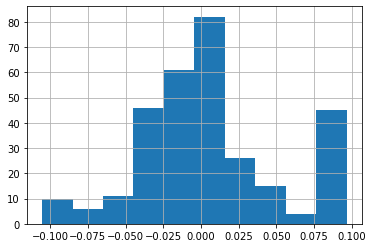

In [12]:
log_rtn.hist()
plt.show()

## Fit ARMA Model

In [15]:
import pandas as pd
import itertools
import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.arima_model import ARIMA

p = range(5)
q = range(5)

combinations = list(itertools.product(p, q))
combinations = combinations[1:] # Drop (0,0)
def train_ARMA(param):
    try:
        p = param[0]
        q = param[1]
        model = ARIMA(log_rtn, order=(p,0,q))

        model_fit = model.fit(disp=0)

        ljung_p = sm.stats.acorr_ljungbox(model_fit.resid, lags=[12], return_df=True).values[0][1]
        aic = model_fit.aic
        return {'p': p, 'q': q, 'ljung_p': ljung_p, 'aic': aic}
    except:
        print(param)

results = pd.DataFrame(columns=['p', 'q', 'ljung_p', 'aic'])
for pq in combinations:
    results = results.append(train_ARMA(pq), ignore_index=True) 

results[results['ljung_p']>=0.05].sort_values(by=['aic'])

(1, 2)
(1, 3)
(1, 4)
(2, 3)


,p,q,ljung_p,aic
15,4.0,0.0,0.835318,-1044.795329
13,3.0,3.0,0.463573,-1044.511055
16,4.0,1.0,0.887142,-1043.333160
14,3.0,4.0,0.574863,-1043.223264
11,3.0,1.0,0.749192,-1043.011571
3,0.0,4.0,0.814687,-1042.396468
12,3.0,2.0,0.822462,-1042.121568
17,4.0,2.0,0.890105,-1041.377596
10,3.0,0.0,0.495588,-1041.129867
9,2.0,4.0,0.811926,-1039.545284


## GARCH

In [13]:
mean = log_rtn.mean() # The mean closes to 0

### Check if volatility time dependency

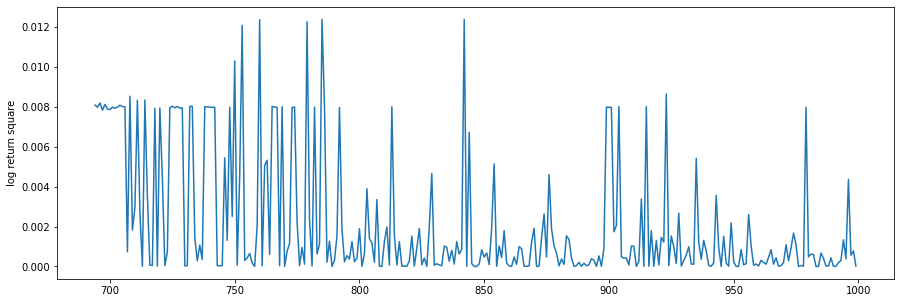

In [14]:
#log return square 
log_rtn_square = np.square(log_rtn - mean)
log_rtn_square.plot(figsize=(15,5))
plt.ylabel('log return square')
plt.show()

In [15]:
import statsmodels.api as sm

p_2 = sm.stats.acorr_ljungbox(log_rtn_square, lags=[40], return_df=True)['lb_pvalue'].values[0] # log return square is white noise if p < 0.05

print(f"P-value for squared log return: {p_2}")
if (p_2<0.05):
    print("Conclusion: Has ARCH's property in log rtn")
else:
    print("Conclusion: No ARCH's property in log rtn")

P-value for squared log return: 6.069005398915473e-89
Conclusion: Has ARCH's property in log rtn


In [20]:
from arch.univariate import arch_model
import itertools
import warnings
warnings.filterwarnings("ignore")

p = range(1,4)
q = range(1,4)

combinations = list(itertools.product(p, q))

def train_GARCH(param):
    p = param[0]
    q = param[1]
    model = arch_model(log_rtn, mean='constant', p=p, q=q)
    
    res = model.fit(update_freq=0)
    
    ljung_p = sm.stats.acorr_ljungbox(res.std_resid, lags=[12], return_df=True).values[0][1]
    aic = res.aic
    
    return {'p':p, 'q': q, 'alpha': res.params['alpha[1]'], 'beta': res.params['beta[1]'], 'ljung_p': ljung_p, 'aic': aic}

results = pd.DataFrame(columns=['p', 'q', 'alpha', 'beta', 'ljung_p', 'aic'])
for pq in combinations:
    results = results.append(train_GARCH(pq), ignore_index=True) 

results[results['ljung_p']>=0.05].sort_values(by=['aic']) # No GARCH models are satisfactory

Optimization terminated successfully    (Exit mode 0)
            Current function value: -537.8488350738997
            Iterations: 18
            Function evaluations: 117
            Gradient evaluations: 18
Optimization terminated successfully    (Exit mode 0)
            Current function value: -538.2510806625917
            Iterations: 22
            Function evaluations: 156
            Gradient evaluations: 20
Optimization terminated successfully    (Exit mode 0)
            Current function value: -536.381474365528
            Iterations: 7
            Function evaluations: 34
            Gradient evaluations: 3
Optimization terminated successfully    (Exit mode 0)
            Current function value: -537.8488384824102
            Iterations: 20
            Function evaluations: 147
            Gradient evaluations: 19
Optimization terminated successfully    (Exit mode 0)
            Current function value: -538.2510800576113
            Iterations: 28
            Function eva

,p,q,alpha,beta,ljung_p,aic
